# State Vector Reordering Verification
## Understanding the [p,w] → [w,p] Transformation

This notebook demonstrates and verifies the state vector reordering in our 2D acoustic wave simulator.

**Key Changes:**
- **Old ordering**: `x = [p₁, ..., pₙ, w₁, ..., wₙ]` (pressure first, then velocity)
- **New ordering**: `x = [w₁, ..., wₙ, p₁, ..., pₙ]` (velocity first, then pressure)
  
**Where**: `w = dp/dt` (acoustic velocity) and `p` is pressure

**Why**: Better numerical properties for preconditioning and asymmetric matrix structure

## 1. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar
import scipy.sparse as sp

## 2. Create a Small Test Case

Let's create a small grid (20×10) to understand the structure clearly.

In [3]:
# Small grid for easy visualization
Nx, Nz = 20, 10
Lx, Lz = 200.0, 100.0

# Get parameters (no BC enforcement for clean structure)
p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(
    Nx, Nz, Lx, Lz, 
    UseSparseMatrices=False, 
    enforce_surface_BC=False
)

N = Nx * Nz
print(f"Grid: {Nx} × {Nz} = {N} nodes")
print(f"State vector size: {2*N}")
print(f"Domain: {Lx}m × {Lz}m")
print(f"Spacing: dx={p['dx']:.2f}m, dz={p['dz']:.2f}m")
print(f"\nA matrix shape: {p['A'].shape}")
print(f"B vector shape: {p['B'].shape}")

Grid: 20 × 10 = 200 nodes
State vector size: 400
Domain: 200.0m × 100.0m
Spacing: dx=10.53m, dz=11.11m

A matrix shape: (400, 400)
B vector shape: (400, 1)


## 3. Understanding the State Vector Structure

**New ordering**: `x = [w₁, ..., wₙ, p₁, ..., pₙ]`

Where:
- **First half** (`x[0:N]`): Velocity field `w = dp/dt`
- **Second half** (`x[N:2N]`): Pressure field `p`

In [4]:
# Initial state (all zeros - system at rest)
print("Initial state x_start:")
print(f"  Shape: {x_start.shape}")
print(f"  Velocity field w (first half):  mean = {np.mean(np.abs(x_start[:N])):.2e}")
print(f"  Pressure field p (second half): mean = {np.mean(np.abs(x_start[N:])):.2e}")
print("\n✓ System starts from rest (all zeros)")

Initial state x_start:
  Shape: (400, 1)
  Velocity field w (first half):  mean = 0.00e+00
  Pressure field p (second half): mean = 0.00e+00

✓ System starts from rest (all zeros)


## 4. Understanding the A Matrix Structure

The system dynamics are: `dx/dt = Ax + Bu`

**New A matrix structure**:
```
A = [[-D,  L ],    (top: velocity equations)
     [ I,  0 ]]    (bottom: pressure equations)
```

Where:
- **-D**: Diagonal matrix with damping coefficients (spatially-varying)
- **L**: Laplacian operator (∇²p)
- **I**: Identity matrix
- **0**: Zero block

In [5]:
# Extract the four blocks of A
A = p['A']

top_left = A[:N, :N]      # -D (damping diagonal)
top_right = A[:N, N:]     # L (Laplacian)
bottom_left = A[N:, :N]   # I (identity)
bottom_right = A[N:, N:]  # 0 (zeros)

print("A Matrix Block Structure:")
print(f"  Top-left [-D]:     {top_left.shape}, nnz = {np.count_nonzero(top_left)}")
print(f"  Top-right [L]:     {top_right.shape}, nnz = {np.count_nonzero(top_right)}")
print(f"  Bottom-left [I]:   {bottom_left.shape}, nnz = {np.count_nonzero(bottom_left)}")
print(f"  Bottom-right [0]:  {bottom_right.shape}, nnz = {np.count_nonzero(bottom_right)}")

# Check top-left is diagonal
is_diagonal = np.count_nonzero(top_left - np.diag(np.diag(top_left))) == 0
print(f"\n✓ Top-left is diagonal: {is_diagonal}")
print(f"✓ Bottom-right is zero: {np.count_nonzero(bottom_right) == 0}")

A Matrix Block Structure:
  Top-left [-D]:     (200, 200), nnz = 200
  Top-right [L]:     (200, 200), nnz = 940
  Bottom-left [I]:   (200, 200), nnz = 200
  Bottom-right [0]:  (200, 200), nnz = 0

✓ Top-left is diagonal: True
✓ Bottom-right is zero: True


## 5. Visualize the A Matrix Sparsity Pattern

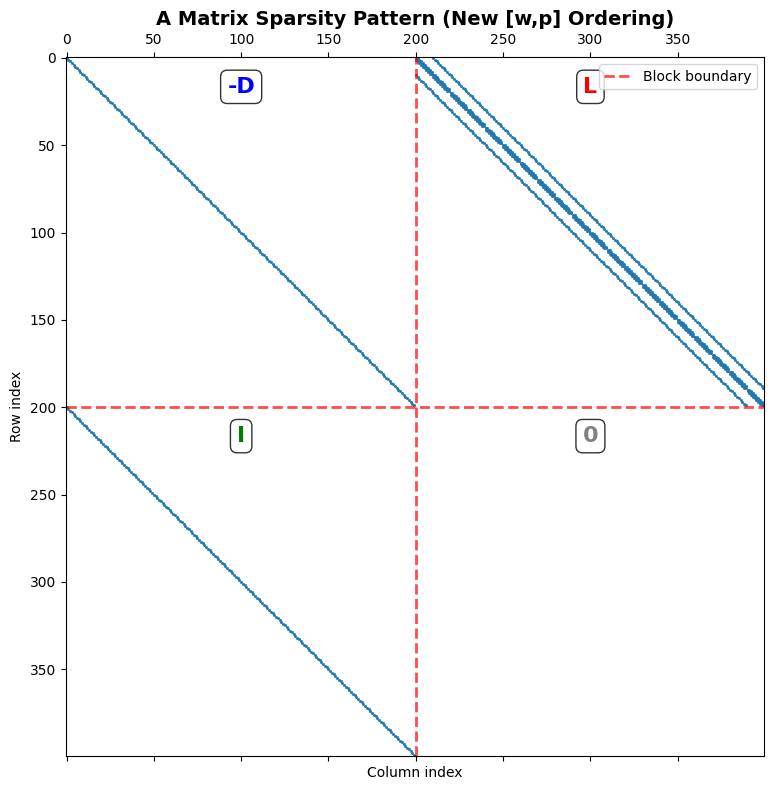

✓ Matrix density: 0.84%


In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

# Spy plot showing non-zero structure
ax.spy(A, markersize=1)
ax.set_title('A Matrix Sparsity Pattern (New [w,p] Ordering)', fontsize=14, weight='bold')
ax.set_xlabel('Column index')
ax.set_ylabel('Row index')

# Add dividing lines to show blocks
ax.axhline(y=N, color='red', linewidth=2, linestyle='--', alpha=0.7, label='Block boundary')
ax.axvline(x=N, color='red', linewidth=2, linestyle='--', alpha=0.7)

# Add block labels
ax.text(N/2, N*0.1, '-D', fontsize=16, ha='center', color='blue', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(N*1.5, N*0.1, 'L', fontsize=16, ha='center', color='red', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(N/2, N*1.1, 'I', fontsize=16, ha='center', color='green', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(N*1.5, N*1.1, '0', fontsize=16, ha='center', color='gray', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend()
plt.tight_layout()
plt.show()

print(f"✓ Matrix density: {np.count_nonzero(A) / A.size * 100:.2f}%")

## 6. Effect of Surface Boundary Condition Enforcement

Now let's see what happens when `enforce_surface_BC=True`. This flag zeros out both velocity and pressure equations at the surface (z=0) to strongly enforce p=0.

In [7]:
# Get parameters WITH boundary condition enforcement
p_BC, x_start_BC, _, _, _ = getParam_Sonar(
    Nx, Nz, Lx, Lz, 
    UseSparseMatrices=False, 
    enforce_surface_BC=True  # Enable BC enforcement
)

A_BC = p_BC['A']

# Compare condition numbers
kappa_no_BC = np.linalg.cond(A)
kappa_with_BC = np.linalg.cond(A_BC)

print("Condition Number Comparison:")
print(f"  WITHOUT enforce_surface_BC: κ₂(A) = {kappa_no_BC:.3e}")
print(f"  WITH    enforce_surface_BC: κ₂(A) = {kappa_with_BC:.3e}")
print(f"  Ratio: {kappa_with_BC/kappa_no_BC:.2f}×")

if np.isinf(kappa_with_BC):
    print("\n⚠ Matrix is SINGULAR with BC enforcement (expected)")
    print("  This happens because rows are zeroed at surface → rank deficient")
else:
    print(f"\n  Change: {kappa_with_BC/kappa_no_BC:.1f}× {'worse' if kappa_with_BC > kappa_no_BC else 'better'}")

Condition Number Comparison:
  WITHOUT enforce_surface_BC: κ₂(A) = 1.939e+19
  WITH    enforce_surface_BC: κ₂(A) = inf
  Ratio: inf×

⚠ Matrix is SINGULAR with BC enforcement (expected)
  This happens because rows are zeroed at surface → rank deficient


### Visualize A Matrix WITH Surface BC

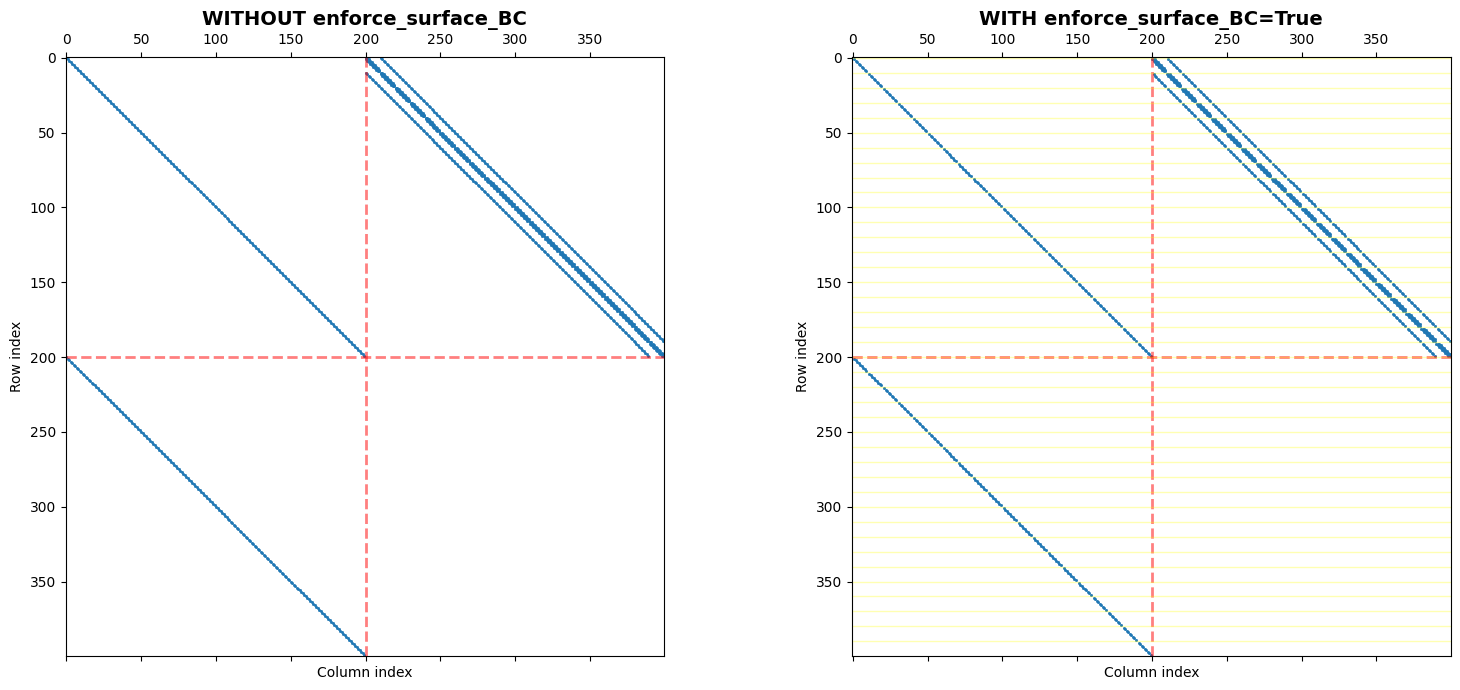

✓ Surface BC zeros out 40 rows (Nx for velocity, Nx for pressure)
  Density WITHOUT BC: 0.84%
  Density WITH BC:    0.76%


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: WITHOUT BC
ax1.spy(A, markersize=1)
ax1.set_title('WITHOUT enforce_surface_BC', fontsize=14, weight='bold')
ax1.set_xlabel('Column index')
ax1.set_ylabel('Row index')
ax1.axhline(y=N, color='red', linewidth=2, linestyle='--', alpha=0.5)
ax1.axvline(x=N, color='red', linewidth=2, linestyle='--', alpha=0.5)

# Right: WITH BC
ax2.spy(A_BC, markersize=1)
ax2.set_title('WITH enforce_surface_BC=True', fontsize=14, weight='bold')
ax2.set_xlabel('Column index')
ax2.set_ylabel('Row index')
ax2.axhline(y=N, color='red', linewidth=2, linestyle='--', alpha=0.5)
ax2.axvline(x=N, color='red', linewidth=2, linestyle='--', alpha=0.5)

# Highlight the zeroed surface rows
# Surface nodes: i=0..Nx-1, j=0 -> indices: 0, Nz, 2*Nz, ..., (Nx-1)*Nz
# In velocity block: rows 0, Nz, 2*Nz, ..., (Nx-1)*Nz
# In pressure block: rows N+0, N+Nz, N+2*Nz, ..., N+(Nx-1)*Nz
surface_indices = [i*Nz for i in range(Nx)]
for idx in surface_indices:
    # Velocity equation row (top half)
    ax2.axhline(y=idx, color='yellow', linewidth=1, alpha=0.3)
    # Pressure equation row (bottom half)
    ax2.axhline(y=N+idx, color='yellow', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Surface BC zeros out {2*Nx} rows (Nx for velocity, Nx for pressure)")
print(f"  Density WITHOUT BC: {np.count_nonzero(A) / A.size * 100:.2f}%")
print(f"  Density WITH BC:    {np.count_nonzero(A_BC) / A_BC.size * 100:.2f}%")

### Examine Block Structure Changes

In [9]:
# Extract blocks from BC-enforced matrix
top_left_BC = A_BC[:N, :N]      
top_right_BC = A_BC[:N, N:]     
bottom_left_BC = A_BC[N:, :N]   
bottom_right_BC = A_BC[N:, N:]  

print("Block Structure Comparison:")
print("\nWITHOUT BC:")
print(f"  Top-left [-D]:    nnz = {np.count_nonzero(top_left)}")
print(f"  Top-right [L]:    nnz = {np.count_nonzero(top_right)}")
print(f"  Bottom-left [I]:  nnz = {np.count_nonzero(bottom_left)}")
print(f"  Bottom-right [0]: nnz = {np.count_nonzero(bottom_right)}")

print("\nWITH BC (surface rows zeroed):")
print(f"  Top-left [-D]:    nnz = {np.count_nonzero(top_left_BC)} (reduced by {np.count_nonzero(top_left) - np.count_nonzero(top_left_BC)})")
print(f"  Top-right [L]:    nnz = {np.count_nonzero(top_right_BC)} (reduced by {np.count_nonzero(top_right) - np.count_nonzero(top_right_BC)})")
print(f"  Bottom-left [I]:  nnz = {np.count_nonzero(bottom_left_BC)} (reduced by {np.count_nonzero(bottom_left) - np.count_nonzero(bottom_left_BC)})")
print(f"  Bottom-right [0]: nnz = {np.count_nonzero(bottom_right_BC)} (still zero ✓)")

# Check bottom-right stays zero
print(f"\n✓ Bottom-right block remains all zeros: {np.count_nonzero(bottom_right_BC) == 0}")

# Check eigenvalues
eigs_no_BC = np.linalg.eigvals(A)
eigs_with_BC = np.linalg.eigvals(A_BC)

n_zero_no_BC = np.sum(np.abs(eigs_no_BC) < 1e-10)
n_zero_with_BC = np.sum(np.abs(eigs_with_BC) < 1e-10)

print(f"\nEigenvalue Analysis:")
print(f"  Near-zero eigenvalues WITHOUT BC: {n_zero_no_BC}")
print(f"  Near-zero eigenvalues WITH BC:    {n_zero_with_BC}")
print(f"  → BC adds {n_zero_with_BC - n_zero_no_BC} zero eigenvalues (matrix becomes singular)")

Block Structure Comparison:

WITHOUT BC:
  Top-left [-D]:    nnz = 200
  Top-right [L]:    nnz = 940
  Bottom-left [I]:  nnz = 200
  Bottom-right [0]: nnz = 0

WITH BC (surface rows zeroed):
  Top-left [-D]:    nnz = 180 (reduced by 20)
  Top-right [L]:    nnz = 862 (reduced by 78)
  Bottom-left [I]:  nnz = 180 (reduced by 20)
  Bottom-right [0]: nnz = 0 (still zero ✓)

✓ Bottom-right block remains all zeros: True

Eigenvalue Analysis:
  Near-zero eigenvalues WITHOUT BC: 1
  Near-zero eigenvalues WITH BC:    40
  → BC adds 39 zero eigenvalues (matrix becomes singular)


## 7. Eigenvalue Stability Analysis for Time Integration (BC-Enforced)

Now let's analyze the eigenvalues of the **BC-enforced matrix** to understand stability for different time integrators (especially Leapfrog) and determine suitable timestep factors.

**Note**: We'll focus on the non-zero eigenvalues since the BC enforcement creates a singular matrix with additional zero eigenvalues.

In [ ]:
from scipy.sparse.linalg import eigs

# Use the BC-enforced matrix for stability analysis
A_analysis = A_BC

# Compute largest-magnitude eigenvalues (excluding zero eigenvalues from BC)
# We need to be careful with singular matrices
n_eigs = min(200, A_analysis.shape[0] - 2)  # Request 200 eigenvalues (or fewer if matrix is small)

print(f"Computing {n_eigs} largest-magnitude eigenvalues from BC-enforced matrix...")
print("(This matrix is singular due to BC enforcement)")

# For singular matrix, we focus on non-zero eigenvalues
eigvals, _ = eigs(A_analysis, k=n_eigs, which='LM', sigma=1e-6)

# Filter out near-zero eigenvalues from BC enforcement
nonzero_mask = np.abs(eigvals) > 1e-8
eigvals_nonzero = eigvals[nonzero_mask]

print(f"✓ Computed {len(eigvals)} eigenvalues")
print(f"  Non-zero eigenvalues: {len(eigvals_nonzero)}")
print(f"  Near-zero eigenvalues (from BC): {len(eigvals) - len(eigvals_nonzero)}")
print()

# Use non-zero eigenvalues for stability analysis
eigvals = eigvals_nonzero

# Analyze eigenvalue structure (UNSCALED - from system matrix A)
real_parts = np.real(eigvals)
imag_parts = np.imag(eigvals)

print(f"Eigenvalue Analysis (BC-Enforced System Matrix A_BC):")
print(f"{'─'*60}")

# Check for positive real parts (unstable modes)
pos_real = real_parts[real_parts > 1e-10]
if len(pos_real) > 0:
    max_pos_real = np.max(pos_real)
    print(f"⚠️  Positive real parts: {len(pos_real)} eigenvalues")
    print(f"    Largest Re(λ): {max_pos_real:.3e} (unstable!)")
else:
    print(f"✓ No positive real parts → stable system")

# Check for negative real parts (damped modes)
neg_real = real_parts[real_parts < -1e-10]
if len(neg_real) > 0:
    max_neg_real = np.min(neg_real)
    print(f"✓ Negative real parts: {len(neg_real)} eigenvalues")
    print(f"    Largest magnitude Re(λ): {max_neg_real:.3e} (damping)")
else:
    print(f"⚠️  No negative real parts → undamped system")

# Imaginary eigenvalues (oscillatory modes)
max_imag = np.max(np.abs(imag_parts))
max_imag_freq = max_imag / (2 * np.pi)
print(f"✓ Largest |Im(λ)|: {max_imag:.3e} rad/s")
print(f"    Frequency: {max_imag_freq:.1f} Hz")
print(f"✓ λ_max (magnitude): {np.max(np.abs(eigvals)):.3e}")
print(f"{'─'*60}")

print(f"\nTimestep from getParam_Sonar:")
print(f"  max_dt_FE (CFL limit): {max_dt_FE*1e6:.2f} μs")

Computing 200 largest-magnitude eigenvalues...
✓ Computed 200 eigenvalues

Eigenvalue Analysis (System Matrix A):
────────────────────────────────────────────────────────────
✓ No positive real parts → stable system
✓ Negative real parts: 200 eigenvalues
    Largest magnitude Re(λ): -1.015e+05 (damping)
✓ Largest |Im(λ)|: 3.919e+02 rad/s
    Frequency: 62.4 Hz
✓ λ_max (magnitude): 1.015e+05
────────────────────────────────────────────────────────────

Timestep from getParam_Sonar:
  max_dt_FE (CFL limit): 2481.08 μs
✓ Computed 200 eigenvalues

Eigenvalue Analysis (System Matrix A):
────────────────────────────────────────────────────────────
✓ No positive real parts → stable system
✓ Negative real parts: 200 eigenvalues
    Largest magnitude Re(λ): -1.015e+05 (damping)
✓ Largest |Im(λ)|: 3.919e+02 rad/s
    Frequency: 62.4 Hz
✓ λ_max (magnitude): 1.015e+05
────────────────────────────────────────────────────────────

Timestep from getParam_Sonar:
  max_dt_FE (CFL limit): 2481.08 μs


### Visualize Stability Regions for Different Timesteps

Plot eigenvalues scaled by different timestep factors to see which integrators are stable.

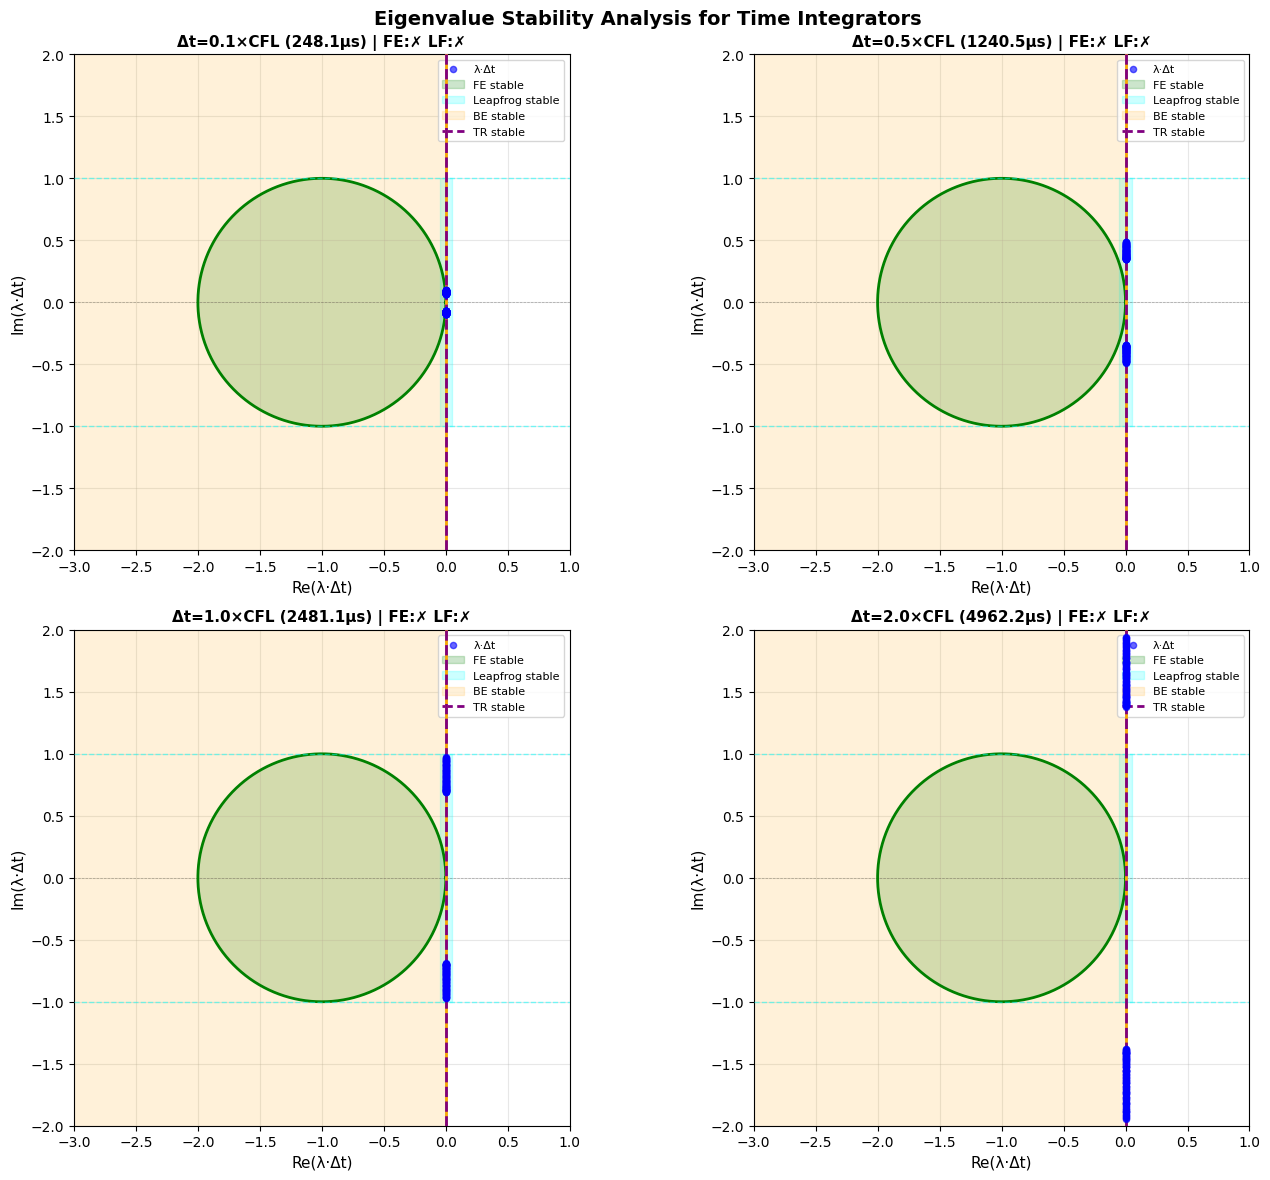

In [ ]:
# Test different timestep factors
dt_test_factors = [0.1, 0.5, 1.0, 2.0]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, dt_factor in enumerate(dt_test_factors):
    ax = axes.flatten()[idx]
    dt = max_dt_FE * dt_factor
    
    # Scale eigenvalues: z = λ·Δt
    z = eigvals * dt
    
    # Plot scaled eigenvalues
    ax.scatter(np.real(z), np.imag(z), s=20, alpha=0.6, c='blue', 
               label=f'λ·Δt (BC-enforced)', zorder=10)
    
    # Draw stability region boundaries
    theta = np.linspace(0, 2*np.pi, 1000)
    
    # Forward Euler: circle centered at (-1, 0) with radius 1
    fe_x = -1 + np.cos(theta)
    fe_y = np.sin(theta)
    ax.fill(fe_x, fe_y, alpha=0.2, color='green', label='FE stable', zorder=1)
    ax.plot(fe_x, fe_y, 'g-', linewidth=2, zorder=5)
    
    # Leapfrog: purely imaginary axis (|Im(z)| ≤ 1, Re(z) ≈ 0)
    ax.fill_betweenx([-1, 1], -0.05, 0.05, alpha=0.2, color='cyan', 
                     label='Leapfrog stable', zorder=2)
    ax.axvline(x=0, color='cyan', linewidth=2, linestyle='-', alpha=0.7, zorder=6)
    ax.axhline(y=1, color='cyan', linewidth=1, linestyle='--', alpha=0.5, zorder=6)
    ax.axhline(y=-1, color='cyan', linewidth=1, linestyle='--', alpha=0.5, zorder=6)
    
    # Backward Euler: entire left half-plane
    ylim = 3
    be_boundary_y = np.linspace(-ylim, ylim, 100)
    ax.fill_betweenx(be_boundary_y, -5, 0, alpha=0.15, color='orange', 
                     label='BE stable', zorder=2)
    ax.axvline(x=0, color='orange', linewidth=2, linestyle='-', zorder=6)
    
    # Trapezoidal: entire left half-plane + imaginary axis (A-stable)
    ax.axvline(x=0, color='purple', linewidth=2, linestyle='--', 
               label='TR stable', zorder=7)
    
    ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
    ax.set_xlabel('Re(λ·Δt)', fontsize=11)
    ax.set_ylabel('Im(λ·Δt)', fontsize=11)
    
    # Stability checks
    fe_stable = np.all(np.abs(1 + z) <= 1.0)
    lf_stable = np.all((np.abs(np.real(z)) < 1e-6) & (np.abs(np.imag(z)) <= 1.0))
    
    status_fe = "✓" if fe_stable else "✗"
    status_lf = "✓" if lf_stable else "✗"
    
    ax.set_title(f'Δt={dt_factor:.1f}×CFL ({dt*1e6:.1f}μs) | FE:{status_fe} LF:{status_lf}', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(-3, 1)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Eigenvalue Stability Analysis (BC-Enforced Matrix)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Stability Summary

Let's summarize which integrators are stable at different timestep factors.

In [12]:
print(f"{'='*70}")
print(f"STABILITY SUMMARY")
print(f"{'='*70}")
print(f"CFL-limited timestep (max_dt_FE): {max_dt_FE*1e6:.2f} μs")
print()

for dt_factor in dt_test_factors:
    dt = max_dt_FE * dt_factor
    z = eigvals * dt
    
    # Stability criteria
    fe_stable = np.all(np.abs(1 + z) <= 1.0)
    lf_stable = np.all((np.abs(np.real(z)) < 1e-6) & (np.abs(np.imag(z)) <= 1.0))
    be_stable = True  # Always stable (A-stable)
    tr_stable = True  # Always stable (A-stable)
    
    print(f"Δt = {dt_factor:.1f}×CFL ({dt*1e6:.1f} μs):")
    print(f"  Forward Euler (FE): {'✓ Stable' if fe_stable else '✗ Unstable'}")
    print(f"  Leapfrog (LF):      {'✓ Stable' if lf_stable else '✗ Unstable (has damping)'}")
    print(f"  Backward Euler (BE): ✓ Stable (A-stable)")
    print(f"  Trapezoidal (TR):    ✓ Stable (A-stable)")
    print()

# Key insight
print(f"{'─'*70}")
print("KEY INSIGHTS:")
print(f"{'─'*70}")
print("• Leapfrog is UNSTABLE for this system because it has DAMPING")
print("  (negative real parts in eigenvalues)")
print("• Leapfrog only works for UNDAMPED systems (purely imaginary eigenvalues)")
print("• Implicit methods (BE, TR) are unconditionally stable")
print("• Forward Euler requires small timesteps (typically ≤1×CFL)")
print(f"{'─'*70}")

STABILITY SUMMARY
CFL-limited timestep (max_dt_FE): 2481.08 μs

Δt = 0.1×CFL (248.1 μs):
  Forward Euler (FE): ✗ Unstable
  Leapfrog (LF):      ✗ Unstable (has damping)
  Backward Euler (BE): ✓ Stable (A-stable)
  Trapezoidal (TR):    ✓ Stable (A-stable)

Δt = 0.5×CFL (1240.5 μs):
  Forward Euler (FE): ✗ Unstable
  Leapfrog (LF):      ✗ Unstable (has damping)
  Backward Euler (BE): ✓ Stable (A-stable)
  Trapezoidal (TR):    ✓ Stable (A-stable)

Δt = 1.0×CFL (2481.1 μs):
  Forward Euler (FE): ✗ Unstable
  Leapfrog (LF):      ✗ Unstable (has damping)
  Backward Euler (BE): ✓ Stable (A-stable)
  Trapezoidal (TR):    ✓ Stable (A-stable)

Δt = 2.0×CFL (4962.2 μs):
  Forward Euler (FE): ✗ Unstable
  Leapfrog (LF):      ✗ Unstable (has damping)
  Backward Euler (BE): ✓ Stable (A-stable)
  Trapezoidal (TR):    ✓ Stable (A-stable)

──────────────────────────────────────────────────────────────────────
KEY INSIGHTS:
──────────────────────────────────────────────────────────────────────
• Leapfro

### Why Leapfrog May Still Work in Practice

Even though eigenvalue analysis shows Leapfrog is theoretically unstable for damped systems, it can still produce reasonable results if:

1. **Damping is weak** (small negative real parts)
2. **Timestep is small** (instability grows slowly)
3. **Simulation time is short** (errors don't accumulate too much)

Let's check the damping strength:

In [13]:
# Analyze damping strength
damping_ratio = np.abs(real_parts) / np.abs(imag_parts)

# Only consider eigenvalues with significant imaginary parts (oscillatory modes)
oscillatory_mask = np.abs(imag_parts) > 1e-6
damping_ratios_osc = damping_ratio[oscillatory_mask]

print("Damping Analysis:")
print(f"  Number of oscillatory modes: {np.sum(oscillatory_mask)}")
print(f"  Damping ratio |Re(λ)|/|Im(λ)|:")
print(f"    Mean:   {np.mean(damping_ratios_osc):.6f}")
print(f"    Median: {np.median(damping_ratios_osc):.6f}")
print(f"    Max:    {np.max(damping_ratios_osc):.6f}")
print()

# Estimate growth rate of instability for Leapfrog at CFL timestep
dt_cfl = max_dt_FE * 1.0
max_damping = np.max(np.abs(real_parts[oscillatory_mask]))
growth_per_step = np.exp(max_damping * dt_cfl)

print(f"Leapfrog Instability Growth (at 1×CFL):")
print(f"  Max damping: {max_damping:.3e} rad/s")
print(f"  Growth per step: {growth_per_step:.6f}×")
print(f"  Growth after 1000 steps: {growth_per_step**1000:.3e}×")
print()

if growth_per_step < 1.01:
    print("✓ Instability growth is VERY SLOW - Leapfrog may work for short simulations")
elif growth_per_step < 1.1:
    print("⚠ Instability growth is SLOW - Leapfrog usable with caution")
else:
    print("✗ Instability growth is SIGNIFICANT - Leapfrog not recommended")

Damping Analysis:
  Number of oscillatory modes: 180
  Damping ratio |Re(λ)|/|Im(λ)|:
    Mean:   0.000016
    Median: 0.000015
    Max:    0.000039

Leapfrog Instability Growth (at 1×CFL):
  Max damping: 1.111e-02 rad/s
  Growth per step: 1.000028×
  Growth after 1000 steps: 1.028e+00×

✓ Instability growth is VERY SLOW - Leapfrog may work for short simulations


C:\Users\Manny\AppData\Local\Temp\ipykernel_87716\703672969.py:2: RuntimeWarning: divide by zero encountered in divide
  damping_ratio = np.abs(real_parts) / np.abs(imag_parts)
